# Deepfake Detection Training Pipeline
## Command Center for Google Colab Pro

This notebook orchestrates the complete training pipeline:
1. Environment setup (gcsfuse, dependencies)
2. Data loading and splitting
3. Model training with best checkpoint saving
4. Evaluation and persistence

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
import os

# Get the current working directory (where the notebook is running)
current_dir = os.getcwd()

# Get the parent directory (project root)
project_root = "/content/drive/MyDrive/Computer_Vision/XAI-in-Deepfake-images-recognition/"

# 3. Change the working directory
try:
    os.chdir(project_root)
    print(f"✅ Changed working directory to: {os.getcwd()}")
except FileNotFoundError:
    print(f"❌ Error: Could not find directory: {project_root}")
    print("Please check the path in your Google Drive.")

# 4. Add the project root to sys.path
# This ensures imports like 'from src.data_loader import ...' work correctly.
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path")

✅ Changed working directory to: /content/drive/MyDrive/Computer_Vision/XAI-in-Deepfake-images-recognition
Added '/content/drive/MyDrive/Computer_Vision/XAI-in-Deepfake-images-recognition/' to sys.path


## 1. Install Dependencies

In [6]:
# Install requiremen/content/drive/MyDrive/Computer_Vision/XAI-in-Deepfake-images-recognition/ts
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 148.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 149.0 MB/s eta 0:00:00


## 2. Mount Google Cloud Storage with gcsfuse

In [7]:
from google.auth import default as get_google_auth_default
import google.auth

In [8]:
# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

In [9]:
import os
os.makedirs('/content/gcs_data', exist_ok=True)

In [10]:
!gsutil -m cp -r gs://dlcv_preprocess_pic/* /content/gcs_data/

Streaming output truncated to the last 5000 lines.
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000200.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000220.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000240.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000280.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000260.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000320.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000340.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000300.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000360.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00216/00216_frame_000380.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00217/00217_frame_000020.jpg...
Copying gs://dlcv_preprocess_pic/YouTube-real/00217/00217_frame_000000.jpg...
Copying gs://

## 3. Import Modules

In [11]:
import sys
import os

# Add parent directory to path for imports
sys.path.insert(0, os.path.abspath('..'))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Import our custom modules
from src.data_loader import get_data_mixed_structure, LocalImageDataset, save_splits, load_splits
from src.preprocessing import get_transforms
from src.models import get_model
from src.trainer import main_training_loop, test_model
from configs.config import Config

print("All modules imported successfully!")

All modules imported successfully!


## 4. Configuration

In [12]:
# # Create necessary directories
# Config.create_directories()

# # Verify GCS mount
# if Config.validate_paths():
#     print("✓ GCS mount verified")
# else:
#     print("⚠ Warning: GCS mount point not found. Check your gcsfuse setup.")

# Set random seed for reproducibility
torch.manual_seed(Config.SEED)

# Get device
device = Config.get_device()
print(f"Using device: {device}")

# # Display configuration
# print("\nConfiguration:")
# for key, value in Config.get_config_dict().items():
#     print(f"  {key}: {value}")

Using device: cuda


## 5. Model Selection

In [13]:
# Choose model architecture
MODEL_NAME = 'efficientnet_b4'  # Options: resnet34, efficientnet_b4, vit_b_16

# Determine model type for preprocessing
MODEL_TYPE = 'vit' if 'vit' in MODEL_NAME else 'cnn'

print(f"Selected model: {MODEL_NAME}")
print(f"Model type: {MODEL_TYPE}")

Selected model: efficientnet_b4
Model type: cnn


## 6. Data Loading and Splitting

In [14]:
# Option 1: Create new splits
CREATE_NEW_SPLITS = False

if CREATE_NEW_SPLITS:
    print("Creating new data splits...")

    train_data, val_data, test_data = get_data_mixed_structure(
        celeb_real_path=Config.PATHS['celeb_real'],
        youtube_real_path=Config.PATHS['youtube_real'],
        celeb_synthesis_path=Config.PATHS['celeb_synthesis'],
        ffhq_real_path=Config.PATHS['ffhq_real'],
        stylegan_fake_path=Config.PATHS['stylegan_fake'],
        stablediffusion_fake_path=Config.PATHS['stablediffusion_fake'],
        train_ratio=Config.TRAIN_RATIO,
        val_ratio=Config.VAL_RATIO,
        test_ratio=Config.TEST_RATIO,
        seed=Config.SEED,
        # max_samples_per_category=1000  # Uncomment for quick debugging
    )

    # Save splits for reproducibility
    splits_path = os.path.join(Config.SPLITS_DIR, f'{MODEL_NAME}_splits.pkl')
    save_splits(train_data, val_data, test_data, splits_path)

else:
    # Option 2: Load existing splits
    print("Loading existing splits...")
    splits_path = os.path.join(Config.SPLITS_DIR, 'data_splits.pkl')
    train_data, val_data, test_data = load_splits(splits_path)

Loading existing splits...
Splits loaded from ./splits/data_splits.pkl
Train: 54448 images
Val:   11645 images
Test:  11623 images


## 7. Create Datasets and DataLoaders

In [15]:
# Get transforms
train_transform = get_transforms(split='train', model_type=MODEL_TYPE, img_size=Config.IMG_SIZE)
val_transform = get_transforms(split='val', model_type=MODEL_TYPE, img_size=Config.IMG_SIZE)

# Create datasets
train_dataset = LocalImageDataset(train_data[0], train_data[1], transform=train_transform)
val_dataset = LocalImageDataset(val_data[0], val_data[1], transform=val_transform)
test_dataset = LocalImageDataset(test_data[0], test_data[1], transform=val_transform)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


DataLoaders created:
  Train batches: 1702
  Val batches:   364
  Test batches:  364


## 8. Initialize Model, Loss, and Optimizer

In [16]:
# Create model
model = get_model(
    model_name=MODEL_NAME,
    num_classes=Config.NUM_CLASSES,
    pretrained=Config.PRETRAINED,
    device=device
)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("\nModel initialized and ready for training!")

Loading efficientnet_b4 (pretrained=True)...
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 242MB/s]


Model loaded successfully on cuda
Output classes: 2

Model initialized and ready for training!


## 9. Train Model

In [18]:
# Run training loop
history = main_training_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=Config.NUM_EPOCHS,
    device=device,
    checkpoint_dir=Config.CHECKPOINT_DIR,
    model_name=MODEL_NAME,
    patience=Config.PATIENCE,
    min_delta=Config.MIN_DELTA,
    scheduler=scheduler
)


Starting Training: efficientnet_b4
Device: cuda
Epochs: 5
Training samples: 54448
Validation samples: 11645


Epoch 1/5
----------------------------------------


Epoch 1 [Val]: 100%|██████████| 364/364 [00:36<00:00, 10.10it/s, loss=0.0875, acc=0.9702]



Epoch 1 Summary:
  Train Loss: 0.0935 | Train Acc: 0.9641
  Val Loss:   0.0875 | Val Acc:   0.9702
  LR: 0.000100
Checkpoint saved to ./checkpoints/efficientnet_b4_best_380.pth
  ✓ New best model saved! (Improvement: +0.9702)

Epoch 2/5
----------------------------------------


Epoch 2 [Val]: 100%|██████████| 364/364 [00:36<00:00, 10.08it/s, loss=0.1065, acc=0.9681]



Epoch 2 Summary:
  Train Loss: 0.0527 | Train Acc: 0.9803
  Val Loss:   0.1065 | Val Acc:   0.9681
  LR: 0.000100
  No improvement for 1 epoch(s)

Epoch 3/5
----------------------------------------


Epoch 3 [Val]: 100%|██████████| 364/364 [00:35<00:00, 10.16it/s, loss=0.0886, acc=0.9773]



Epoch 3 Summary:
  Train Loss: 0.0351 | Train Acc: 0.9866
  Val Loss:   0.0886 | Val Acc:   0.9773
  LR: 0.000100
Checkpoint saved to ./checkpoints/efficientnet_b4_best_380.pth
  ✓ New best model saved! (Improvement: +0.0071)

Epoch 4/5
----------------------------------------


Epoch 4 [Val]: 100%|██████████| 364/364 [00:35<00:00, 10.13it/s, loss=0.0876, acc=0.9770]



Epoch 4 Summary:
  Train Loss: 0.0273 | Train Acc: 0.9899
  Val Loss:   0.0876 | Val Acc:   0.9770
  LR: 0.000100
  No improvement for 1 epoch(s)

Epoch 5/5
----------------------------------------


Epoch 5 [Val]: 100%|██████████| 364/364 [00:35<00:00, 10.24it/s, loss=0.0839, acc=0.9803]



Epoch 5 Summary:
  Train Loss: 0.0216 | Train Acc: 0.9921
  Val Loss:   0.0839 | Val Acc:   0.9803
  LR: 0.000010
Checkpoint saved to ./checkpoints/efficientnet_b4_best_380.pth
  ✓ New best model saved! (Improvement: +0.0030)
Checkpoint saved to ./checkpoints/efficientnet_b4_epoch_5.pth

Training Complete!
Total time: 33.66 minutes
Best validation accuracy: 0.9803 at epoch 5



## 10. Plot Training History

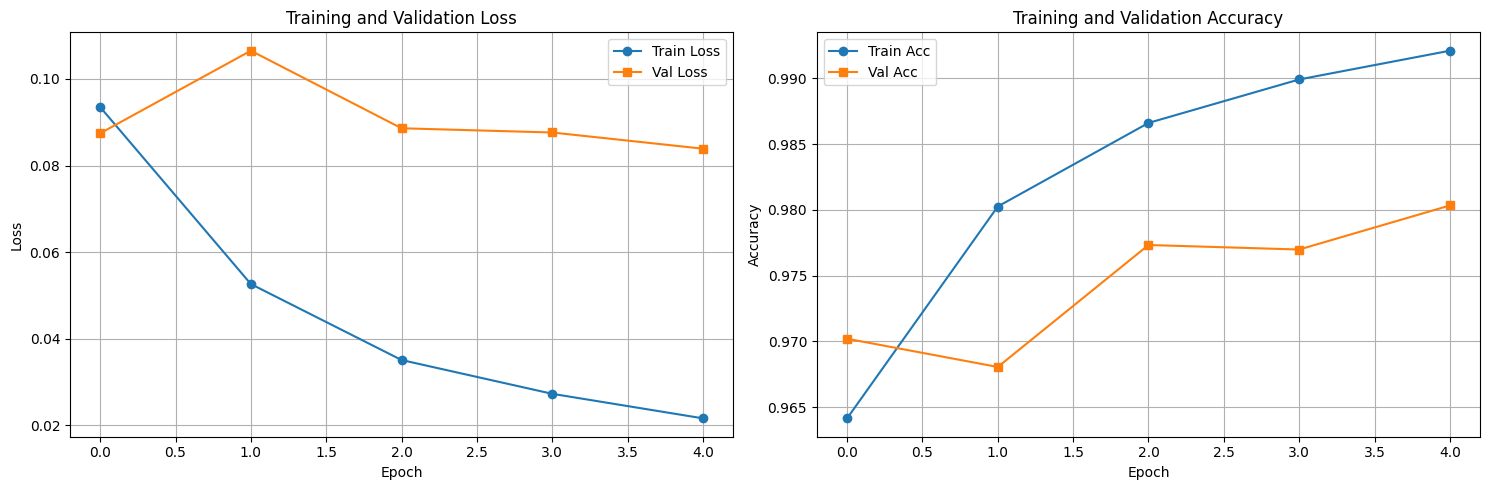

Training plots saved to ./logs/efficientnet_b4_training_history.png


In [19]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(f'{Config.LOGS_DIR}/{MODEL_NAME}_training_history.png', dpi=150)
plt.show()

print(f"Training plots saved to {Config.LOGS_DIR}/{MODEL_NAME}_training_history.png")

## 11. Load Best Model and Evaluate on Test Set

## overall eval

### ViT

In [ ]:
from src.models import load_checkpoint
from src.eval import evaluate_test_set, evaluate_per_domain, evaluate_holdout

# Load best model
best_model_path = os.path.join(Config.CHECKPOINT_DIR, f'{MODEL_NAME}_best.pth')
model = load_checkpoint(model, best_model_path, device=device)

# Run Standard Evaluation
criterion = nn.CrossEntropyLoss()
metrics = evaluate_test_set(model, test_loader, criterion, device)

Loading checkpoint from ./checkpoints/vit_b_16_best.pth...
Checkpoint loaded successfully

Running Standard Test Evaluation


Evaluating:   0%|          | 0/364 [00:00<?, ?it/s]


--- Overall Results ---
              precision    recall  f1-score   support

        REAL     0.9405    0.9386    0.9395      3419
        FAKE     0.9744    0.9753    0.9748      8204

    accuracy                         0.9645     11623
   macro avg     0.9575    0.9569    0.9572     11623
weighted avg     0.9644    0.9645    0.9645     11623

AUC Score: 0.9931


### ResNet

In [ ]:
# 1. Define the correct architecture for the weights you want to load
resnet_model = get_model('resnet34', pretrained=False, device=device)

# 2. Define the path to the weights
best_model_path = os.path.join(Config.CHECKPOINT_DIR, 'resnet34_best.pth')

# 3. Load the weights into the MATCHING architecture
resnet_model = load_checkpoint(resnet_model, best_model_path, device=device)

# 4. Run evaluation
# Note: Use the resnet_model you just loaded, not the old 'model' variable
metrics = evaluate_test_set(resnet_model, test_loader, criterion, device)

Loading resnet34 (pretrained=False)...
Model loaded successfully on cuda
Output classes: 2
Loading checkpoint from ./checkpoints/resnet34_best.pth...
Checkpoint loaded successfully

Running Standard Test Evaluation


Evaluating:   0%|          | 0/364 [00:00<?, ?it/s]


--- Overall Results ---
              precision    recall  f1-score   support

        REAL     0.9721    0.8345    0.8980      3419
        FAKE     0.9349    0.9900    0.9616      8204

    accuracy                         0.9442     11623
   macro avg     0.9535    0.9122    0.9298     11623
weighted avg     0.9458    0.9442    0.9429     11623

AUC Score: 0.9870


### EfficientNet

In [21]:
# 1. Define the correct architecture for the weights you want to load
efficientnet_model = get_model('efficientnet_b4', pretrained=False, device=device)

# 2. Define the path to the weights
best_model_path = os.path.join(Config.CHECKPOINT_DIR, 'efficientnet_b4_best.pth')

# 3. Load the weights into the MATCHING architecture
efficientnet_model = load_checkpoint(efficientnet_model, best_model_path, device=device)

# 4. Run evaluation
# Note: Use the resnet_model you just loaded, not the old 'model' variable
metrics = evaluate_test_set(efficientnet_model, test_loader, criterion, device)

Loading efficientnet_b4 (pretrained=False)...
Model loaded successfully on cuda
Output classes: 2
Loading checkpoint from ./checkpoints/efficientnet_b4_best_380.pth...
Checkpoint loaded successfully

Running Standard Test Evaluation


Evaluating:   0%|          | 0/364 [00:00<?, ?it/s]


--- Overall Results ---
              precision    recall  f1-score   support

        REAL     0.9903    0.9544    0.9720      3419
        FAKE     0.9813    0.9961    0.9886      8204

    accuracy                         0.9838     11623
   macro avg     0.9858    0.9752    0.9803     11623
weighted avg     0.9839    0.9838    0.9837     11623

AUC Score: 0.9979


## eval by group

### ViT

In [ ]:
evaluate_per_domain(model, test_dataset, device)


PER-DOMAIN EVALUATION


Predicting:   0%|          | 0/364 [00:00<?, ?it/s]


--- Celeb-real (1716 samples) ---
Accuracy: 94.76%
Predictions: {np.int64(0): np.int64(1626), np.int64(1): np.int64(90)} (0=REAL, 1=FAKE)

--- YouTube-real (1028 samples) ---
Accuracy: 95.82%
Predictions: {np.int64(0): np.int64(985), np.int64(1): np.int64(43)} (0=REAL, 1=FAKE)

--- Celeb-synthesis (6758 samples) ---
Accuracy: 97.19%
Predictions: {np.int64(0): np.int64(190), np.int64(1): np.int64(6568)} (0=REAL, 1=FAKE)

--- FFHQ-real (675 samples) ---
Accuracy: 88.59%
Predictions: {np.int64(0): np.int64(598), np.int64(1): np.int64(77)} (0=REAL, 1=FAKE)

--- StableDiffusion-fake (546 samples) ---
Accuracy: 99.63%
Predictions: {np.int64(0): np.int64(2), np.int64(1): np.int64(544)} (0=REAL, 1=FAKE)

--- StyleGAN-fake (900 samples) ---
Accuracy: 98.78%
Predictions: {np.int64(0): np.int64(11), np.int64(1): np.int64(889)} (0=REAL, 1=FAKE)


### ResNet

In [ ]:
evaluate_per_domain(resnet_model, test_dataset, device)


PER-DOMAIN EVALUATION


Predicting:   0%|          | 0/364 [00:00<?, ?it/s]


--- Celeb-real (1716 samples) ---
Accuracy: 83.39%
Predictions: {np.int64(0): np.int64(1431), np.int64(1): np.int64(285)} (0=REAL, 1=FAKE)

--- YouTube-real (1028 samples) ---
Accuracy: 88.13%
Predictions: {np.int64(0): np.int64(906), np.int64(1): np.int64(122)} (0=REAL, 1=FAKE)

--- Celeb-synthesis (6758 samples) ---
Accuracy: 99.27%
Predictions: {np.int64(0): np.int64(49), np.int64(1): np.int64(6709)} (0=REAL, 1=FAKE)

--- FFHQ-real (675 samples) ---
Accuracy: 76.44%
Predictions: {np.int64(0): np.int64(516), np.int64(1): np.int64(159)} (0=REAL, 1=FAKE)

--- StableDiffusion-fake (546 samples) ---
Accuracy: 98.90%
Predictions: {np.int64(0): np.int64(6), np.int64(1): np.int64(540)} (0=REAL, 1=FAKE)

--- StyleGAN-fake (900 samples) ---
Accuracy: 97.00%
Predictions: {np.int64(0): np.int64(27), np.int64(1): np.int64(873)} (0=REAL, 1=FAKE)


### EfficientNet

In [22]:
evaluate_per_domain(efficientnet_model, test_dataset, device)


PER-DOMAIN EVALUATION


Predicting:   0%|          | 0/364 [00:00<?, ?it/s]


--- Celeb-real (1716 samples) ---
Accuracy: 93.65%
Predictions: {np.int64(0): np.int64(1607), np.int64(1): np.int64(109)} (0=REAL, 1=FAKE)

--- YouTube-real (1028 samples) ---
Accuracy: 97.37%
Predictions: {np.int64(0): np.int64(1001), np.int64(1): np.int64(27)} (0=REAL, 1=FAKE)

--- Celeb-synthesis (6758 samples) ---
Accuracy: 99.53%
Predictions: {np.int64(0): np.int64(32), np.int64(1): np.int64(6726)} (0=REAL, 1=FAKE)

--- FFHQ-real (675 samples) ---
Accuracy: 97.04%
Predictions: {np.int64(0): np.int64(655), np.int64(1): np.int64(20)} (0=REAL, 1=FAKE)

--- StableDiffusion-fake (546 samples) ---
Accuracy: 100.00%
Predictions: {np.int64(1): np.int64(546)} (0=REAL, 1=FAKE)

--- StyleGAN-fake (900 samples) ---
Accuracy: 100.00%
Predictions: {np.int64(1): np.int64(900)} (0=REAL, 1=FAKE)


## eval hold-out-set

### ViT

In [ ]:
GCS_MOUNT_POINT = "/content/gcs_data"
HOLDOUT_DIR = os.path.join(GCS_MOUNT_POINT, 'holdout_test')
evaluate_holdout(
        model=model,
        holdout_dir=HOLDOUT_DIR,
        model_type='vit' if 'vit' in MODEL_NAME else 'cnn',
        device=device
    )


HOLDOUT EVALUATION: /content/gcs_data/holdout_test
Found 3212 images (1606 Real, 1606 Fake)


Holdout Inference:   0%|          | 0/101 [00:00<?, ?it/s]


--- Holdout Results ---
              precision    recall  f1-score   support

        REAL     0.5377    0.7684    0.6327      1606
        FAKE     0.5943    0.3394    0.4320      1606

    accuracy                         0.5539      3212
   macro avg     0.5660    0.5539    0.5323      3212
weighted avg     0.5660    0.5539    0.5323      3212

AUC Score: 0.5714
Confusion Matrix:
[[1234  372]
 [1061  545]]


### ResNet

In [ ]:
evaluate_holdout(
        model=resnet_model,
        holdout_dir=HOLDOUT_DIR,
        model_type='vit' if 'vit' in MODEL_NAME else 'cnn',
        device=device
    )


HOLDOUT EVALUATION: /content/gcs_data/holdout_test
Found 3212 images (1606 Real, 1606 Fake)


Holdout Inference:   0%|          | 0/101 [00:00<?, ?it/s]


--- Holdout Results ---
              precision    recall  f1-score   support

        REAL     0.3895    0.5093    0.4414      1606
        FAKE     0.2914    0.2017    0.2384      1606

    accuracy                         0.3555      3212
   macro avg     0.3404    0.3555    0.3399      3212
weighted avg     0.3404    0.3555    0.3399      3212

AUC Score: 0.3496
Confusion Matrix:
[[ 818  788]
 [1282  324]]


### EfficientNet

In [25]:
evaluate_holdout(
        model=efficientnet_model,
        holdout_dir=HOLDOUT_DIR,
        model_type='vit' if 'vit' in MODEL_NAME else 'cnn',
        device=device
    )


HOLDOUT EVALUATION: /content/gcs_data/holdout_test
Found 3212 images (1606 Real, 1606 Fake)


Holdout Inference:   0%|          | 0/101 [00:00<?, ?it/s]


--- Holdout Results ---
              precision    recall  f1-score   support

        REAL     0.6013    0.1775    0.2740      1606
        FAKE     0.5175    0.8823    0.6524      1606

    accuracy                         0.5299      3212
   macro avg     0.5594    0.5299    0.4632      3212
weighted avg     0.5594    0.5299    0.4632      3212

AUC Score: 0.6766
Confusion Matrix:
[[ 285 1321]
 [ 189 1417]]


## 12. Save Model for Streamlit App

In [26]:
# Save model in simple format for inference
inference_model_path = f'{MODEL_NAME}.pth'
torch.save(model.state_dict(), inference_model_path)

print(f"Model saved for inference: {inference_model_path}")
print(f"Download this file to use with the Streamlit app!")

# Download to local machine (in Colab)
from google.colab import files
files.download(inference_model_path)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dd2206d2700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 1136, in wait
    ready = selector.select(timeout)
            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
    

Model saved for inference: efficientnet_b4_380.pth
Download this file to use with the Streamlit app!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 13. Export the file

In [24]:
import json
import os

# 1. Define the path to your notebook
notebook_path = "/content/drive/MyDrive/Computer_Vision/XAI-in-Deepfake-images-recognition/notebooks/main_training.ipynb"

# 2. Load the notebook as a JSON object
try:
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb_data = json.load(f)
    print("✅ Notebook loaded successfully.")

    # 3. Remove the 'widgets' key from metadata if it exists
    if 'metadata' in nb_data and 'widgets' in nb_data['metadata']:
        del nb_data['metadata']['widgets']
        print("🗑️  Deleted 'widgets' key from metadata.")

        # 4. Save the cleaned notebook back to disk
        with open(notebook_path, 'w', encoding='utf-8') as f:
            json.dump(nb_data, f, indent=1)
        print("💾 Notebook saved. The corrupt widget state is gone.")

    else:
        print("ℹ️  No 'widgets' key found in metadata. The file might already be clean.")

except FileNotFoundError:
    print(f"❌ Error: Could not find file at {notebook_path}")
except json.JSONDecodeError:
    print("❌ Error: The notebook file is not valid JSON.")

✅ Notebook loaded successfully.
🗑️  Deleted 'widgets' key from metadata.
💾 Notebook saved. The corrupt widget state is gone.


In [27]:
!jupyter nbconvert "/content/drive/MyDrive/Computer_Vision/XAI-in-Deepfake-images-recognition/notebooks/main_training.ipynb" --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Computer_Vision/XAI-in-Deepfake-images-recognition/notebooks/main_training.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.expor